# Çok Değişkenli İstatistik Dersi Projesi

Ders içeriğinde geçen teorik kısmın pratiğe dökülmesi adına böyle bir çalışma yapılmıştır.

Veri seti Türkiyenin 2008-2017 arasındaki Hava Kalitesi verisidir. Aşağıdaki github klasöründen (repo) alınmıştır.
https://github.com/olgnaydn/airqualitr

Öncelikle verinin boyutu büyük olduğu için değişkenlerin aylık ortalama değerleri çıkarılacaktır. Ve yalnızca 4 İl (İstanbul, Ankara, İzmir, Antalya) analiz için seçilmiştir.

In [78]:
import numpy as np
import pandas as pd
from datetime import datetime
np.set_printoptions(suppress=True)

##### Veri Seti

In [2]:
df = pd.read_csv("airquality_data.csv") 

In [3]:
df.shape

(10469286, 29)

Yukarıda gördüğümüz gibi verinin gerçek halinde `10469286` gözlem ve `29` değişken bulunmaktadır.

In [4]:
df.head()

,Unnamed: 0,Mevki,Tarih,PM10,CO,NO,NO2,NOX,O3,PM2.5,...,Nem,Yagmur,o..Ksilen,p..Ksilen,PM10.debi,PM2.5.debi,Sample_Flow,Toluen,long,lat
0,1,ADANA CATALAN,16.12.2008 00:00,24.0,NaN,0.0,5.0,NaN,32.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.290451,37.21336
1,2,ADANA CATALAN,16.12.2008 01:00,21.0,NaN,0.0,4.0,NaN,36.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.290451,37.21336
2,3,ADANA CATALAN,16.12.2008 02:00,14.0,NaN,0.0,3.0,NaN,38.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.290451,37.21336
3,4,ADANA CATALAN,16.12.2008 03:00,18.0,NaN,0.0,3.0,NaN,33.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.290451,37.21336
4,5,ADANA CATALAN,16.12.2008 04:00,15.0,NaN,0.0,2.0,NaN,33.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.290451,37.21336


### Veri Düzenleme ve Temizleme

In [5]:
df = df.join(df['Mevki'].str.split(' ', 1, expand=True).rename(columns={0:'City', 1:'District'}))

In [6]:
df_sample = df[df["City"].isin(["ISTANBUL", "ANKARA", "IZMIR", "ANTALYA"])]

In [7]:
df_sample.shape


(2286477, 31)

Yalnızca 4 il ile gözlem sayımız `2286477`'a düşüyor. Bunun yanında Mevki kolonunda bulunan il ve ilçe bilgisini ikiye böldük. Bunun amacı ile göre gruplama yapabilmektir.

In [8]:
df_sample = df_sample.join(df_sample['Tarih'].str.split(expand=True).rename(columns={0:'Day', 1:'Time'}))
df_sample = df_sample[df_sample["Day"] != "Minimum"]
df_sample["Day"] = df_sample['Day'].str.replace('/', '.')
df_sample["date"] = pd.to_datetime(df_sample["Day"], format="%d.%m.%Y")
df_sample['date'] = df_sample['date'].apply(lambda x: x.strftime('%Y/%m') if not pd.isnull(x) else '')

Yukarıdaki işlemle birlikte Tarih ve Saat bilgisi içeren değişken sadece Ay ve Yıl bilgisi içeren `date` değişkenine çevrildi. Bunun amacı yine gruplama yapmaktır.

In [9]:
display(df_sample["date"].head(1))
df_sample["date"].tail(1)

698419    2008/05
Name: date, dtype: object

6061140    2017/03
Name: date, dtype: object

2018'in beşinci ayından 2017'in üçüncü ayına kadar bir zaman dilimini kapsamaktadır.

#### Değişken Seçimi ve Gruplama

In [10]:
df_sample.columns

Index(['Unnamed: 0', 'Mevki', 'Tarih', 'PM10', 'CO', 'NO', 'NO2', 'NOX', 'O3',
       'PM2.5', 'Hava.Sicakligi', 'Ruzgar.Yönü', 'Ruzgar.Hizi', 'Bagil.Nem',
       'Hava.Basinci', 'Kabin.Sicakligi', 'Benzen', 'Elektrik', 'Etillbenzene',
       'Nem', 'Yagmur', 'o..Ksilen', 'p..Ksilen', 'PM10.debi', 'PM2.5.debi',
       'Sample_Flow', 'Toluen', 'long', 'lat', 'City', 'District', 'Day',
       'Time', 'date'],
      dtype='object')

Yukarıda halihazırdaki değişkenleri görüyoruz. Bunların arasından aşağıda belirtilen değişkenler seçilip bu andan itibaren tüm hesaplamalar bu değişkenlerle yapılacaktır.

In [11]:
columns = ['City','date','Hava.Sicakligi','PM10', 'NO', 'NO2', 'O3','Ruzgar.Hizi','Hava.Basinci']
df_sample = df_sample.loc[:,columns]

In [12]:
df_sample.groupby(["City","date"]).aggregate(np.nanmean).head() # sadece 5 satır

/usr/local/lib/python3.7/site-packages/pandas/core/groupby/groupby.py:1062: RuntimeWarning: Mean of empty slice
  f = lambda x: func(x, *args, **kwargs)


Hava.Sicakligi         PM10         NO        NO2         O3  \
City   date                                                                    
ANKARA 2008/02       -0.955157    89.789238        NaN        NaN        NaN   
       2008/04       13.717546   119.306705  25.786885  30.152012  41.841270   
       2008/05       14.294416  1177.658206  17.742138  52.607966  53.458333   
       2008/06       19.750000  1607.035714   6.472222  39.944444  47.764706   
       2008/07       23.310680    43.852982   7.320611  41.804580  91.787879   

                Ruzgar.Hizi  Hava.Basinci  
City   date                                
ANKARA 2008/02     0.991031    918.087444  
       2008/04     1.368046    914.368046  
       2008/05     1.543147    906.159052  
       2008/06     1.839286    902.339286  
       2008/07     1.244105    907.757282

Yukarıdaki dataframe de sadece 5 satır gösterilmektedir ancak değişkenlerin aylık olarak ortalama değerlerini görebilmekteyiz.

Bazı değişkenler için aylık olarak çok sayıda eksik veri görüyoruz. Eksik veri işlemleri alan bilgisi ve araştırma gerektirir. Özellikle bu eksikliğin rastsal olup olmadığı araştırılmalıdır. Ancak bu örnek için, ortalama değer ataması yapılacaktır.

In [13]:
summary = df_sample.groupby(["City","date"]).aggregate(np.nanmean)

In [14]:
summary = summary.reset_index(level=["City","date"]) # verinin son hali
summary.to_csv("summary_data.csv")

##### Eksik Veri Atanması

Bu yöntemin doğru olmadığının farkında olarak bu işlem yapılacaktır. Bunun en büyük problemlerden biri küçük bir ortalama atamasının böyle büyük bir veri setinde işlemsel maaliyetinin çok yüksek olması. Uzun süren bekleme süresini kısaltmak için böyle bir yol izlenmiştir.

In [16]:
summary = summary.fillna(summary.mean())

# Matris İşlemleri

Öncelikle veri setini Şehir ve Zaman bilgisinden ayırıp matris'e çeviriyoruz.

In [48]:
matrix = summary.drop(["City","date"],axis=1).as_matrix()
matrix

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


array([[  -0.95515695,   89.78923767,   42.58319298, ...,   35.07899354,
           0.99103139,  918.08744395],
       [  13.71754636,  119.30670471,   25.78688525, ...,   41.84126984,
           1.36804565,  914.36804565],
       [  14.29441624, 1177.65820643,   17.74213836, ...,   53.45833333,
           1.54314721,  906.15905245],
       ...,
       [   6.64324324,   60.03626195,    8.15163607, ...,   35.07899354,
           0.        , 1016.96081081],
       [  10.90922619,   49.42457871,   13.09448819, ...,   35.07899354,
           0.        , 1019.31696429],
       [  13.96126761,   43.90598291,   11.61944778, ...,   35.07899354,
           0.        , 1008.61619718]])

In [21]:
matrix.shape #459x7 bir matrix

(459, 7)

In [33]:
row_n = matrix.shape[0]
col_n = matrix.shape[1]

### Ortalama

In [34]:
mean_vector = np.dot(np.ones(row_n).T, matrix) / row_n
mean_vector
# matrix.mean(axis=0) otomatik ortalama bulmak için

array([  8.91127718,  63.48467127,  42.58319298,  52.49717423,
        35.07899354,  -7.37858231, 942.06456457])

### Ortalamalardan Fark

In [49]:
xs = matrix - (np.ones((1,row_n)).T * mean_vector)
xs

array([[  -9.86643413,   26.3045664 ,    0.        , ...,    0.        ,
           8.3696137 ,  -23.97712062],
       [   4.80626918,   55.82203344,  -16.79630773, ...,    6.7622763 ,
           8.74662796,  -27.69651892],
       [   5.38313906, 1114.17353516,  -24.84105462, ...,   18.37933979,
           8.92172952,  -35.90551211],
       ...,
       [  -2.26803394,   -3.44840931,  -34.43155691, ...,    0.        ,
           7.37858231,   74.89624624],
       [   1.99794901,  -14.06009256,  -29.48870479, ...,    0.        ,
           7.37858231,   77.25239972],
       [   5.04999043,  -19.57868836,  -30.9637452 , ...,    0.        ,
           7.37858231,   66.55163262]])

### KÇÇT(SSCP)  

In [51]:
sscp = np.dot(xs.T, xs)
sscp

array([[  155536.59292382,    23068.1275879 ,   -28078.82712874,
          -14122.20391751,    16538.67396751,    39189.05959727,
          928534.80691558],
       [   23068.1275879 ,  3839762.4034413 ,    20946.08876001,
           25072.56745741,    24598.5030003 ,    19241.65220832,
          101057.35559725],
       [  -28078.82712874,    20946.08876001,   254330.80308383,
          115545.86163446,   -64507.65563976,   -77495.42813636,
            4827.33483217],
       [  -14122.20391751,    25072.56745741,   115545.86163446,
          122196.08854003,   -21533.66252417,   -36635.58340244,
          -18332.33070238],
       [   16538.67396751,    24598.5030003 ,   -64507.65563976,
          -21533.66252417,   103900.82634884,    41680.96469965,
            6950.67408596],
       [   39189.05959727,    19241.65220832,   -77495.42813636,
          -36635.58340244,    41680.96469965, 16637798.91497883,
         -180427.89312411],
       [  928534.80691558,   101057.35559725,     48

### Varyans - Covaryans Matrisi

In [63]:
s = sscp / (row_n - 1)
s
# veya np.cov(matrix.T) 

array([[  339.59954787,    50.3670908 ,   -61.30748281,   -30.83450637,
           36.11064185,    85.56563231,  2027.36857405],
       [   50.3670908 ,  8383.7607062 ,    45.73381825,    54.74359707,
           53.70852183,    42.01234107,   220.64924803],
       [  -61.30748281,    45.73381825,   555.30743031,   252.28354069,
         -140.84640969,  -169.20399156,    10.54003238],
       [  -30.83450637,    54.74359707,   252.28354069,   266.80368677,
          -47.0167304 ,   -79.99035677,   -40.02692293],
       [   36.11064185,    53.70852183,  -140.84640969,   -47.0167304 ,
          226.85769945,    91.00647314,    15.17614429],
       [   85.56563231,    42.01234107,  -169.20399156,   -79.99035677,
           91.00647314, 36327.07186677,  -393.9473649 ],
       [ 2027.36857405,   220.64924803,    10.54003238,   -40.02692293,
           15.17614429,  -393.9473649 , 17721.15341962]])

### Korelasyon Matrisi

In [118]:
d = s.diagonal().T * np.identity(7)
d_sqrt_inv = (1 / np.sqrt(d).diagonal()).T * np.identity(7)
d_sqrt_inv

array([[0.05426458, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.01092146, 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.04243588, 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.06122152, 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.06639314,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.00524668, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.00751197]])

In [246]:
r = np.dot(np.dot(d_sqrt_inv, s), d_sqrt_inv)
r

array([[ 1.        ,  0.02984997, -0.14117675, -0.10243716,  0.13009928,
         0.02436131,  0.82642447],
       [ 0.02984997,  1.        ,  0.02119587,  0.03660311,  0.03894458,
         0.00240737,  0.01810244],
       [-0.14117675,  0.02119587,  1.        ,  0.65542992, -0.39682797,
        -0.03767287,  0.00335992],
       [-0.10243716,  0.03660311,  0.65542992,  1.        , -0.19110839,
        -0.02569369, -0.01840816],
       [ 0.13009928,  0.03894458, -0.39682797, -0.19110839,  1.        ,
         0.03170154,  0.007569  ],
       [ 0.02436131,  0.00240737, -0.03767287, -0.02569369,  0.03170154,
         1.        , -0.01552662],
       [ 0.82642447,  0.01810244,  0.00335992, -0.01840816,  0.007569  ,
        -0.01552662,  1.        ]])

Karşılaştırmak için ve yorum yapmak için bir dataframe fonskiyonu olan corr fonksiyonunu kullanarak da sonucu gösteriyoruz.

In [130]:
summary.drop(["City","date"],axis=1).corr()

,Hava.Sicakligi,PM10,NO,NO2,O3,Ruzgar.Hizi,Hava.Basinci
Hava.Sicakligi,1.000000,0.029850,-0.141177,-0.102437,0.130099,0.024361,0.826424
PM10,0.029850,1.000000,0.021196,0.036603,0.038945,0.002407,0.018102
NO,-0.141177,0.021196,1.000000,0.655430,-0.396828,-0.037673,0.003360
NO2,-0.102437,0.036603,0.655430,1.000000,-0.191108,-0.025694,-0.018408
O3,0.130099,0.038945,-0.396828,-0.191108,1.000000,0.031702,0.007569
Ruzgar.Hizi,0.024361,0.002407,-0.037673,-0.025694,0.031702,1.000000,-0.015527
Hava.Basinci,0.826424,0.018102,0.003360,-0.018408,0.007569,-0.015527,1.000000


Hava Basıncı ile Hava Sıcaklığı arasında çok güçlü pozitif bir korelasyon olduğunu görüyoruz. Bununla birlikte NO ve NO2 arasında güçlü diyebileceğimiz pozitif bir ilişki var. Bunun dışında değişkenler arasındaki korelasyon 0'a çok yakın.


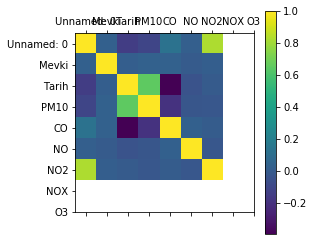

In [245]:
plt.matshow(summary.corr())
plt.xticks(range(len(summary.columns)), df.columns)
plt.yticks(range(len(summary.columns)), df.columns)
plt.colorbar()
plt.show()

# Öz Değerler ve Vektörler

In [244]:
from numpy import linalg as LA
w,v = LA.eig(s)
display(w)
display(v)

array([36336.72309037, 17952.03445732,  8379.46016354,   749.53846094,
         198.56445955,    94.65101727,   109.58270801])

array([[ 0.00120782, -0.11447074, -0.00021775,  0.11196639,  0.15343105,
        -0.96668617,  0.12780939],
       [ 0.00133169, -0.02358384, -0.99965412,  0.00612682, -0.00955491,
         0.00219029, -0.00016895],
       [-0.00475995, -0.00001291, -0.00596029, -0.83353934,  0.0619402 ,
        -0.15628828, -0.52620469],
       [-0.00222942,  0.00247061, -0.00702796, -0.46649396,  0.44296183,
         0.11603148,  0.75673274],
       [ 0.00253549, -0.00126745, -0.0063788 ,  0.27345141,  0.88091373,
         0.12325067, -0.36602715],
       [ 0.99976071, -0.02068375,  0.00180235, -0.00614881, -0.00149075,
         0.00270909, -0.00030358],
       [-0.0210057 , -0.99292735,  0.0237219 , -0.01442456, -0.01745356,
         0.11147046, -0.01236734]])

## Genelleştirilmiş Varyans

In [248]:
LA.det(s)

8.43797488192896e+21

# Çok Değişkenli Normal Dağılım ve Testi

In [141]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.spatial.distance import cdist
import scipy as sp

In [179]:
X = matrix[:,0]
Y = matrix[:,6]
X, Y = np.meshgrid(X, Y)
pos = np.dstack((X, Y))
mu = np.array([X.mean(), Y.mean()])
cov = np.cov(matrix[:,[3,4]].T)
rv = multivariate_normal(mu, cov)
Z = rv.pdf(pos)

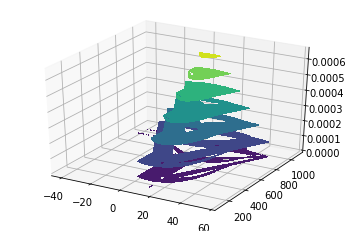

In [180]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.contourf(X, Y, Z)
fig.show()

### Mahalanobis Distance

In [264]:
mu = matrix.mean(axis=0).reshape(1, -1)
s = np.cov(matrix.T)
s_inv = sp.linalg.inv(s)


In [326]:
Q = np.dot(np.dot(mu, s_inv), mu.T)
print("Q value using formula", Q.item())
from scipy.stats import chi
print("Chi Table Value", chi.ppf(q=1-0.05, df=row_n))
print("Hypothesis will be above.")

Q value using formula 169.51415877572637
Chi Table Value 22.582016877596384
Hypothesis will be above.


### Hotelling Tˆ2 Anakütle testi
Test etmek istediğimiz ortalamaların aşağıdaki gibi olduğunu varsayalım.
$$\mu_0 = \Bigg[ 3, 42.9, 10, 20 ,34,  24, 12 \Bigg]$$

Formül olarak ise aşağıdaki gibidir.
$$T^2 = n(\bar{x} - \mu_1)' S^{-1} (\bar{x} - \mu_1)$$


In [272]:
mu_0 = np.array([3, 42.9, 10, 20 ,34,  24, 12])
diff = mu - mu_0
diff

array([[  5.91127718,  20.58467127,  32.58319298,  32.49717423,
          1.07899354, -31.37858231, 930.06456457]])

In [317]:
T_square = row_n * np.dot(np.dot(diff, s_inv), diff.T) 
T_square.item()

69116.13365806705

In [308]:
F_cri = (T_square * ((row_n - col_n) / ((row_n - 1) * col_n))).item()
print("F critical value: ", F_cri)
from scipy.stats import f, chi
print("F table value: ", f.ppf(q=1-0.05, dfn=(row_n-1), dfd=col_n))


F critical value:  9744.383160775516
F table value:  3.2397088416174404


Kritik değer tablo değerinden büyük olduğu için H0'ı kabul edemeyiz.

## BOX M Testi

Python için implementasyonu bulunmadığı için aşağıdaki fonksiyon kullanılmıştır.
Fonksiyonun alındığı kaynak:https://stackoverflow.com/questions/42633083/how-to-perform-a-levenes-test-using-scipy

Ancak bu fonksiyon iki matris istediğinden fonksiyonda değişiklikler yapılacaktır.

In [337]:
def box_m(X0):

        global Xp
        X1 = np.identity(7) # birim matrise cevrildi
        m = 2
        k = len(np.cov(X0))
        n_1 = len(X0[0])
        n_2 = len(X0[0])
        n = len(X0[0])+len(X0[0])

        Xp = ( ((n_1-1)*np.cov(X0)) + ((n_2-1)*X1) ) / (n-m)

        M = ((n-m)*np.log(np.linalg.det(Xp))) \
         - (n_1-1)*(np.log(np.linalg.det(np.cov(X0)))) - (n_2-1)*(np.log(np.linalg.det(X1)))

        c = ( ( 2*(k**2) + (3*k) - 1 ) / ( (6*(k+1)*(m-1)) ) ) \
            * ( (1/(n_1-1)) + (1/(n_2-1)) - (1/(n-m)) )

        df = (k*(k+1)*(m-1))/2

        c2 = ( ((k-1)*(k+2)) / (6*(m-1)) ) \
            * ( (1/((n_1-1)**2)) + (1/((n_2-1)**2)) - (1/((n-m)**2)) )

        df2 = (df+2) / (np.abs(c2-c**2))

        if (c2>c**2):

            a_plus = df / (1-c-(df/df2))

            F = M / a_plus

        else:

            a_minus = df2 / (1-c+(2/df2))

            F = (df2*M) / (df*(a_minus-M))

        print('M = {}'.format(M))
        print('c = {}'.format(c))
        print('c2 = {}'.format(c2))
        print('-------------------')
        print('df = {}'.format(df))
        print('df2 = {}'.format(df2))
        print('-------------------')
        print('F = {}'.format(F))
        print("F Table Value {}".format(f.ppf(q=1-0.05, dfd=28, dfn=2923752)))

$$H_0: S = I $$
$$H_0: S \neq I $$
Varyans Kovaryans matrisimizin birim matrise eşit olup olmadığını test edeceğiz.

In [338]:
box_m(matrix.T)

M = 18702.5560022685
c = 0.008051310043668122
c2 = 7.508438054194237e-05
-------------------
df = 28.0
df2 = 2923752.304900179
-------------------
F = 662.564171995325
F Table Value 1.6540790477885248


# MANOVA

In [229]:
from statsmodels.multivariate.manova import MANOVA